In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
df_copy = df.copy()

df_copy.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


## Model Building

In [ ]:
x=pd.DataFrame(df_copy,columns=['gender', 'age','hypertension','heart_disease','smoking_history','bmi','HbA1c_level','blood_glucose_level'])

y=df_copy.diabetes.values.reshape(-1,1)# Target variable

In [ ]:
x_train, x_test, y_train,y_test= train_test_split(x,y, test_size= 0.20, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(x_train,y_train.ravel())
y_pred_clf = clf.predict (x_test)

In [ ]:
print("Accuracy: " ,metrics.accuracy_score(y_test,y_pred_clf))

Accuracy:  0.970566822672907


In [ ]:
regressor = DecisionTreeRegressor(max_depth=5,
        min_samples_split=32,
        min_samples_leaf=16,
        random_state=42
    )
regressor.fit(x_train,y_train)
y_pred_reg = regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)

In [ ]:
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

MSE: 0.025765718705345535
RMSE: 0.1605170355611688
R2 Score: 0.6838023655524524


## Visualization

### Classifier Tree

In [ ]:
from sklearn import tree

In [ ]:
text_representation=tree.export_text(clf)
print(text_representation)

|--- feature_6 <= 6.70
|   |--- feature_7 <= 210.00
|   |   |--- feature_1 <= 53.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  53.50
|   |   |   |--- class: 0
|   |--- feature_7 >  210.00
|   |   |--- class: 1
|--- feature_6 >  6.70
|   |--- class: 1



In [ ]:
with open('decision_tree.log' ,'w') as fout:
    fout.write (text_representation)

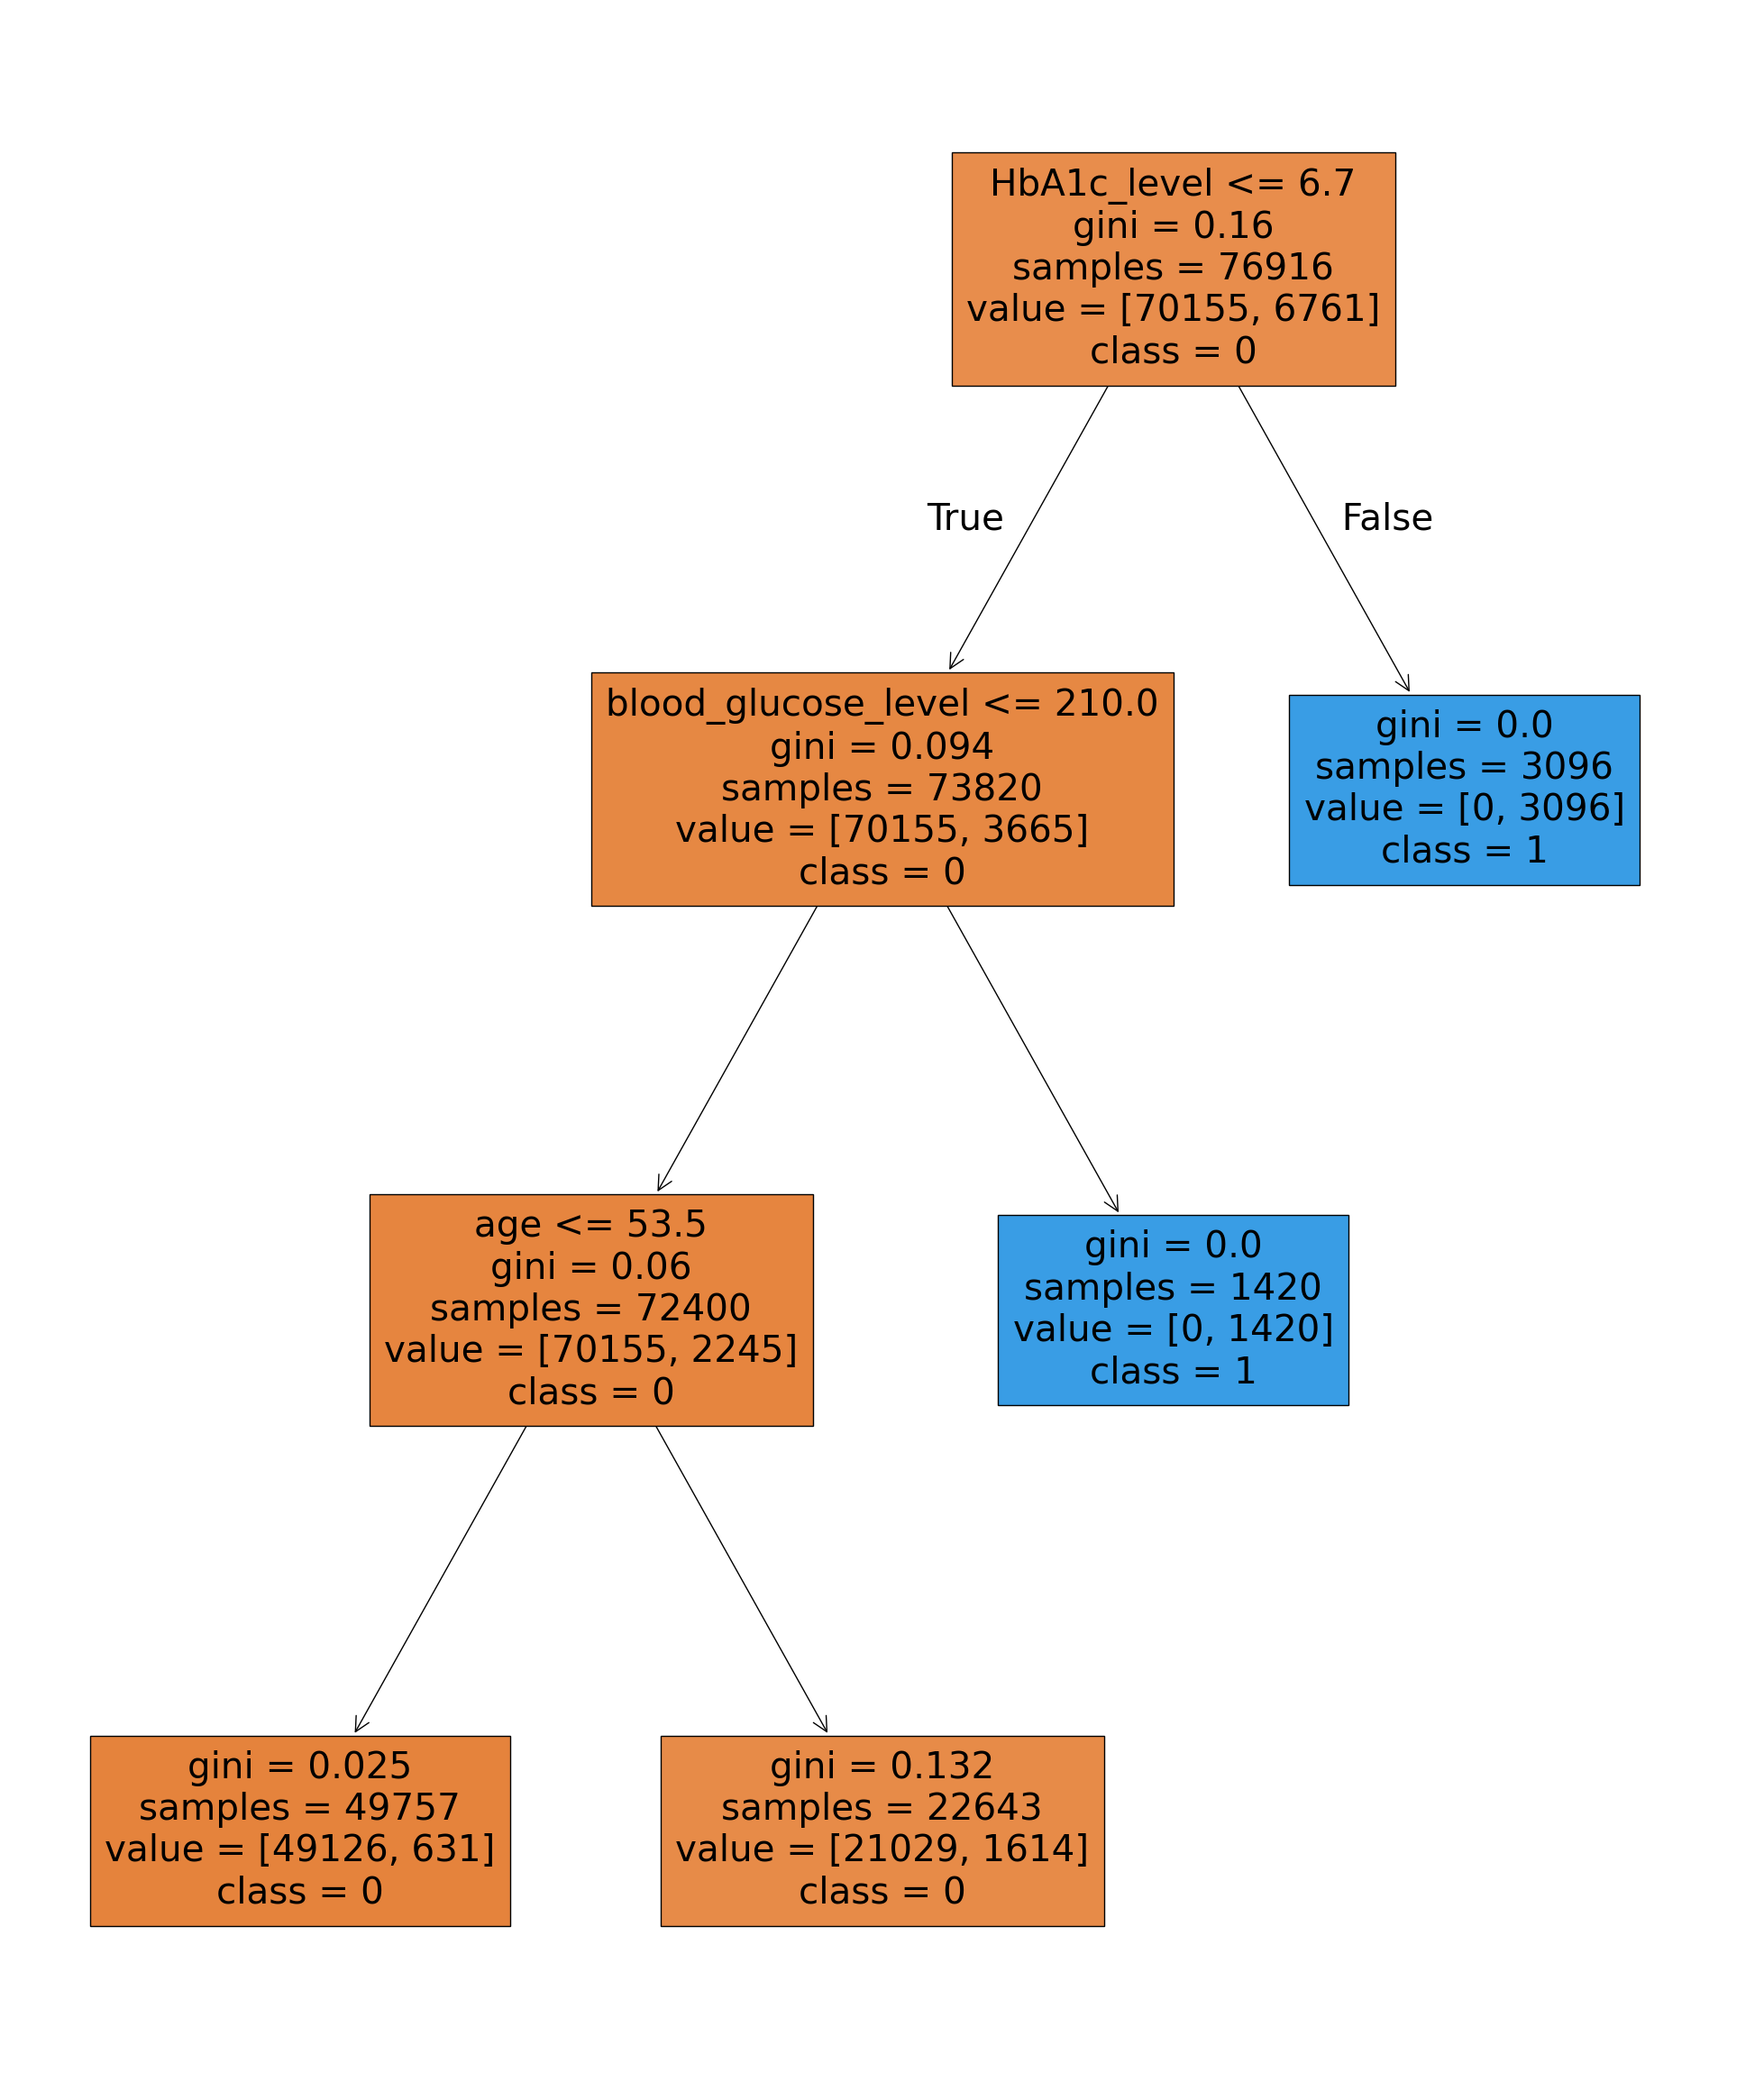

In [ ]:
feature_names=['gender', 'age','hypertension','heart_disease','smoking_history','bmi','HbA1c_level','blood_glucose_level']
target_names=['0','1']
fig= plt.figure(figsize=(25,30))
plot= tree.plot_tree (clf,
                     feature_names=feature_names,
                     class_names=target_names,
                     filled=True)

### Regression Tree

In [ ]:
def visualize_regression_tree(regressor, feature_names):
    plt.figure(figsize=(20,10))
    plot_tree(regressor, feature_names=feature_names,
             filled=True, rounded=True)
    plt.show()

In [ ]:
feature_names=['gender', 'age','hypertension','heart_disease','smoking_history','bmi','HbA1c_level','blood_glucose_level']

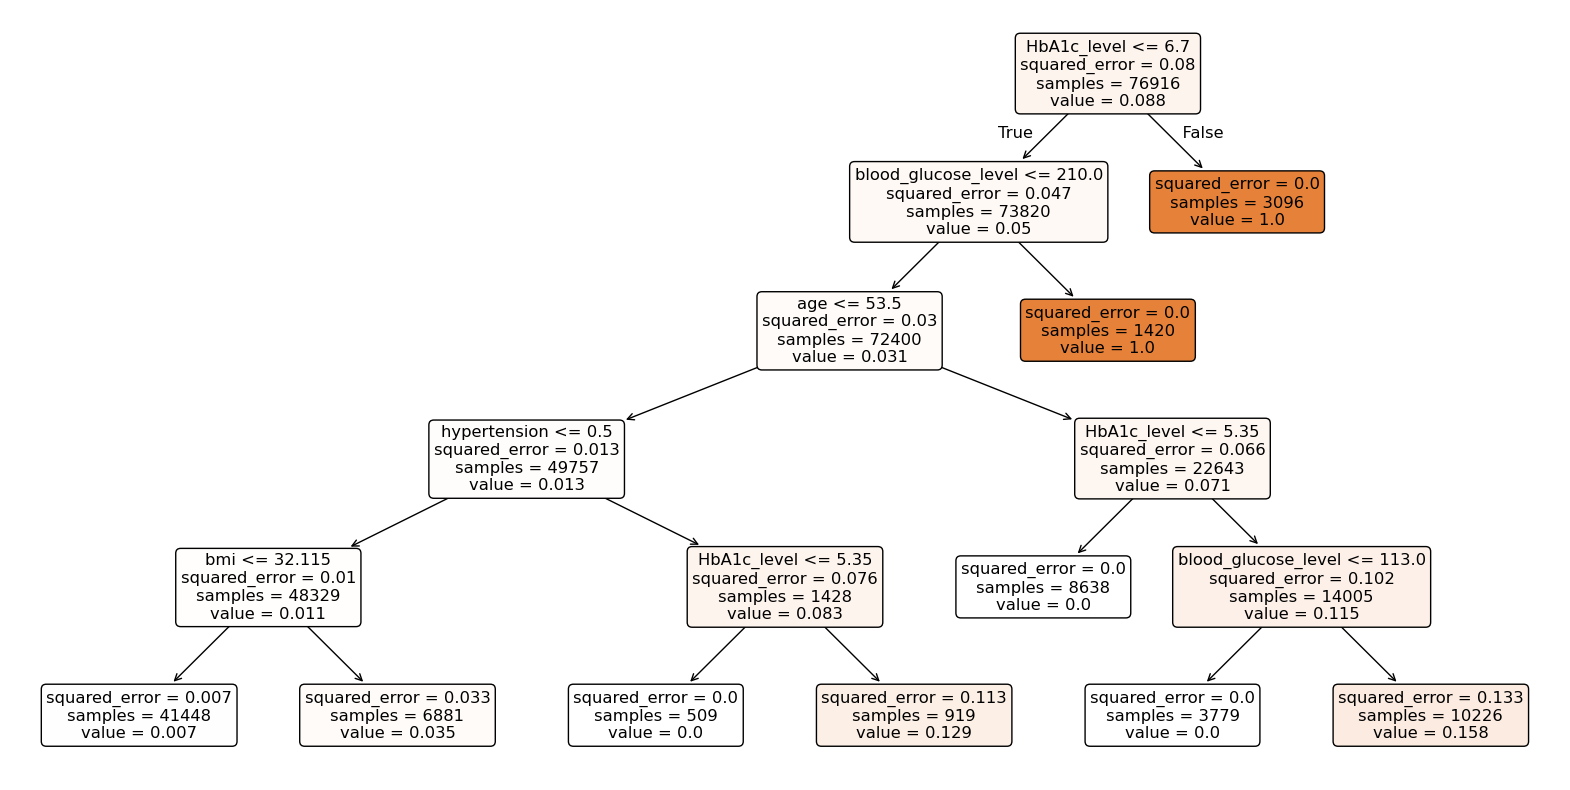

In [ ]:
visualize_regression_tree(regressor, feature_names)